# An example of crafting an ESN experiment using SpineML

In [1]:
from __future__ import division

from libSpineML import smlExperiment as exp
from libSpineML import smlNetwork as net
from libSpineML import smlComponent as com
from libSpineML.smlUtils import  create_spineml_network
from libSpineML.smlUtils import  process_connection_json

from libSpineML.smlUtils import  extract_adjacency_matrix
from libSpineML.smlUtils import  inject_adjacency_matrix
from libSpineML.smlUtils import set_esn_weights

from matplotlib import pyplot as plt

import csv
import sys

import cStringIO
import graphviz as gv
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

import copy
import pickle

import pickle
lpu_dict = pickle.load(( open( "../neuroarch_example/spineml/lpu_dicts.p", "rb" ) ))
connections_json = pickle.load(( open( "../neuroarch_example/spineml/example_connections_json.p", "rb" ) ))


# Build an ESN implementation

We can pass in a custom neuron parameters dictionary to specify the ESN network components


In [2]:
neuron_params = {'mem_model':
                            {'name':'ESNNode', 'filename':'ESNNode.xml'},
                         'weight_update' :
                            {'name':'ESNWeight', 'filename':'ESNWeight.xml','override':{}},
                         'synapse' :
                            {'name':'ESNConnection', 'filename':'ESNConnection.xml'},
                         'input_model':
                            {'name':'ESNInput', 'filename':'ESNInput.xml'},
                        }

# Overwrite Weights 

Creating SpineML representation...
Creating ESN weights...
Creating SpineML Files
Done


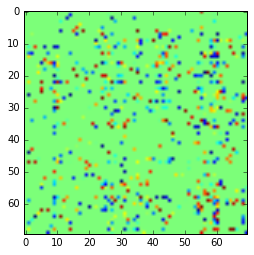

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.12226836,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        , -0.38694286]])

In [3]:
neurons, populations, projections = process_connection_json(connections_json,lpu_dict,neuron_params = neuron_params) 
print "Creating SpineML representation..."


spectral_radius=1.0
print "Creating ESN weights..."
populations,projections,adjacency_matrix = set_esn_weights(populations,projections, spectral_radius=1.0,weight_parameter='w')

print "Creating SpineML Files"
create_spineml_network(neurons, populations,
projections,output_filename='ESN_files/esn_network.xml',project_name= 'drosophila')

print "Done"

adjacency_matrix, neuron_index = extract_adjacency_matrix(populations,projections,weight_parameter='w')
plt.imshow(adjacency_matrix)
plt.show()
adjacency_matrix

# Create Echo State Inputs

## TODO

1. Identify all the input nodes and their connections
2. Add the input nodes and links to the system
3. Create an experiment
4. Add inputs and output to the experiment


## 1. Identify all the input nodes and their connections


In [4]:
cartridges = [k.split('-')[1] for k in neurons.keys() if 'L1' in k]
input_neurons = ['L1','L2','L4']

input_nodes = []


for c in cartridges:
    name = str("Input_%s" % c).encode('utf8')
    input_nodes.append(name)
    connections_json['nodes'][name] = {u'class':  u'Input', u'name': name , u'uname': name}

# Add input connections

# for every Input node
for c in cartridges:
    print "Adding Input to cartridge %s" %c
    for n in input_neurons:
        
        pre = str("Input_%s" % c).encode('utf8')
        post = "%s-%s" %(n,c)
        if post in neurons:
            print "> neuron %s" % post
            if pre not in connections_json['edges']: connections_json['edges'][pre] ={}
            if post not in connections_json['edges'][pre]: connections_json['edges'][pre][post] ={}
            connections_json['edges'][pre][post] = {u'inferred': 0, u'synapses': 1}


Adding Input to cartridge home
> neuron L1-home
Adding Input to cartridge R
> neuron L1-R
Adding Input to cartridge P
> neuron L1-P
Adding Input to cartridge Q
> neuron L1-Q
Adding Input to cartridge B
> neuron L1-B
Adding Input to cartridge C
> neuron L1-C
Adding Input to cartridge A
> neuron L1-A
Adding Input to cartridge F
> neuron L1-F
Adding Input to cartridge D
> neuron L1-D
Adding Input to cartridge E
> neuron L1-E
Adding Input to cartridge J
> neuron L1-J
Adding Input to cartridge K
> neuron L1-K
Adding Input to cartridge L
> neuron L1-L


 Adding Input Node: Input_D  
 Adding Input Node: Input_E  
 Adding Input Node: Input_B  
 Adding Input Node: Input_R  
 Adding Input Node: Input_A  
 Adding Input Node: Input_L  
 Adding Input Node: Input_J  
 Adding Input Node: Input_Q  
 Adding Input Node: Input_P  
 Adding Input Node: Input_C  
 Adding Input Node: Input_K  
 Adding Input Node: Input_F  
 Adding Input Node: Input_home  
Creating SpineML representation...
Creating ESN weights...
done


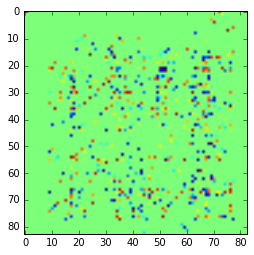

In [5]:
neuron_params = {'mem_model':
                            {'name':'ESNNode', 'filename':'ESNNode.xml'},
                         'weight_update' :
                            {'name':'ESNWeight', 'filename':'ESNWeight.xml','override':{'w':0.2}},
                         'synapse' :
                            {'name':'ESNConnection', 'filename':'ESNConnection.xml'},
                         'input_model':
                            {'name':'ESNInput', 'filename':'ESNInput.xml'}
                }

neurons, populations, projections = process_connection_json(connections_json,lpu_dict,neuron_params = neuron_params) 
print "Creating SpineML representation..."

spectral_radius=1.0
print "Creating ESN weights..."
populations,projections,adjacency_matrix = set_esn_weights(populations,projections, spectral_radius=1.0,weight_parameter='w')


project = create_spineml_network(neurons, populations,
projections,output_filename='ESN_files/test_esn_network.xml',network_name='test_esn_network',project_name= 'drosophila')

print "done"

adjacency_matrix, neuron_index = extract_adjacency_matrix(populations,projections, weight_parameter='w')
plt.imshow(adjacency_matrix)
plt.show()

# Create an Experiment with Input

In [25]:
SpineMLExperiment = exp.SpineMLType()
experiment = exp.ExperimentType()
experiment.name = "ESN"
experiment.description = "NeuroNLP-spineML bridge"
experiment.Simulation = exp.SimulationType(duration=10,preferred_simulator='BRAHMS')

#TODO set Integration MEthod: exp.EulerIntegrationType(dt=1)

In [26]:
steps = 1000
input_signals = {i : np.random.rand(steps) for i in input_nodes}


In [27]:
for i in input_nodes:
    # Create a Time Varying Array
    tv = exp.TimeVaryingInputType(
        name="%s_data" % i,
        target=i,
        target_indices=0,
        port='Input',
        start_time=0,
        duration=steps
    )
    
    for time,value in enumerate(input_signals[i]):
            tv.add_TimePointValue(exp.TimePointValueType(time=str(time),value=str(value)))
    
    experiment.add_AbstractInput(tv)

In [28]:
SpineMLExperiment.add_Experiment(experiment)

# Create a Project File

In [29]:
from libSpineML import smlBundle

In [30]:
b = smlBundle.Bundle()
b.add_experiment(SpineMLExperiment)
b.add_network(project['network']['component']);
b.add_component(component='ESN_files/ESNInput.xml')
b.add_component(component='ESN_files/ESNNode.xml')
b.add_component(component='ESN_files/ESNWeight.xml')
b.add_component(component='ESN_files/ESNConnection.xml')
b.create_project()

b.export_project('project.proj',project_file='test_project/')
